In [2]:
import argparse
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Configuration
DEFAULT_PKL = pd.read_pickle('../../data/transactions_with_respend(4).pkl')
EPOCH_DURATION_MINUTES = 30  # 30-minute epochs as per mission plan
Q_MAX = 10  # Maximum quantile bins for time-cost

In [ ]:
print(DEFAULT_PKL.columns)
print(len(DEFAULT_PKL))

Index(['inputs_hash', 'tx_id', 'found_at', 'mined_at', 'pruned_at',
       'child_txid', 'absolute_fee', 'fee_rate', 'version', 'seen_in_mempool',
       'waittime', 'rbf_fee_total', 'mempool_size', 'mempool_tx_count',
       'weight', 'size', 'respend_child_txid', 'respend_timestamp'],
      dtype='object')
Index(['tx_id', 'found_at', 'found_at_dt', 'respend_timestamp',
       'respend_delay_seconds', 'time_cost', 'epoch'],
      dtype='object')
991334
696424


In [ ]:
# Use the main dataset directly (already includes respend/time_cost info)
df = DEFAULT_PKL.copy()

print(df.columns)
print(len(df))

Index(['inputs_hash', 'tx_id', 'found_at', 'mined_at', 'pruned_at',
       'child_txid', 'absolute_fee', 'fee_rate', 'version', 'seen_in_mempool',
       'waittime', 'rbf_fee_total', 'mempool_size', 'mempool_tx_count',
       'weight', 'size', 'respend_child_txid', 'respend_timestamp',
       'time_cost'],
      dtype='object')
696424


In [6]:
def create_epochs(df, epoch_duration_minutes=EPOCH_DURATION_MINUTES):
    """
    Partition timeline into epochs as per mission plan.
    Each epoch is EPOCH_DURATION_MINUTES long.
    """
    # Create time bins based on found_at timestamps
    start_time = df['found_at'].min()
    end_time = df['found_at'].max()
    
    # Create epoch boundaries (in seconds)
    epoch_seconds = epoch_duration_minutes * 60
    num_epochs = int(np.ceil((end_time - start_time) / epoch_seconds))
    
    bins = np.linspace(start_time, start_time + (num_epochs * epoch_seconds), num_epochs + 1)
    
    # Assign each transaction to an epoch
    df['epoch'] = pd.cut(df['found_at'], bins=bins, labels=False, include_lowest=True)
    
    print(f"✓ Created {num_epochs} epochs of {epoch_duration_minutes} minutes each")
    print(f"  Time range: {pd.to_datetime(start_time, unit='s')} to {pd.to_datetime(end_time, unit='s')}")
    
    return df

df = create_epochs(df)

✓ Created 91 epochs of 30 minutes each
  Time range: 2025-06-24 19:21:21 to 2025-06-26 16:47:02


In [7]:
def compute_time_cost(df):
    """
    Compute re-spend delay and its inverse as proxy for time-cost (impatience)
    using the externally fetched re-spend data from mempool.space.
    """
    print("Computing time-cost proxy …")

    # qcut → 0-based codes, +1 to get the human-friendly 1…Q_MAX scale
    qcodes = pd.qcut(
        df["time_cost"],
        q=Q_MAX,
        labels=False,
        duplicates="drop"
    )

    df["time_cost_quantile"] = (qcodes + 1).astype("Int64")   # <-- key line
    print(f"✓ Binned into {Q_MAX} quantiles")
    return df

def compute_tail_distribution(df):
    tail_dist = []

    # build the table
    for epoch in sorted(df["epoch"].dropna().unique()):
        epoch_data = df[df["epoch"] == epoch]
        for q in range(1, Q_MAX + 1):
            upper = (epoch_data["time_cost_quantile"] >= q).sum()
            total = epoch_data["time_cost_quantile"].notna().sum()
            if total:
                tail_dist.append({"epoch": epoch, "quantile": q,
                                  "F_tq": upper / total})

    tail_df = pd.DataFrame(tail_dist, dtype="Float64")           # <- nullable ints

    # make sure *both* keys are the same dtype
    tail_df["quantile"] = tail_df["quantile"].astype("Int64")

    df = df.merge(
        tail_df[["epoch", "quantile", "F_tq"]],
        left_on=["epoch", "time_cost_quantile"],
        right_on=["epoch", "quantile"],
        how="left"
    )
    print(f"✓ Computed F^t(q) for {len(tail_df)} epoch–quantile pairs")
    return df


df = compute_time_cost(df)
df = compute_tail_distribution(df)


Computing time-cost proxy …
✓ Binned into 10 quantiles
✓ Computed F^t(q) for 910 epoch–quantile pairs


In [8]:
#sanity check
print(df[["epoch", "time_cost_quantile", "F_tq"]].head())
print(df["F_tq"].isna().mean())      # should be 0 unless a quantile/epoch combo is empty


   epoch  time_cost_quantile      F_tq
0     90                   1       1.0
1     90                   4  0.652222
2     90                   9   0.16674
3     90                   9   0.16674
4     90                   5  0.587769
0.0


In [9]:
def compute_mempool_congestion(df):
    """
    Compute mempool congestion (ρ̂t) for each epoch using an event-based approach.

    This method models the mempool as a queue, with transactions entering at
    'found_at' and leaving at 'mined_at' or 'pruned_at'. It calculates a running
    count of transactions in the mempool over time. The initial congestion is
    estimated from the 'mempool_tx_count' of the first transaction in the
    dataset. The congestion for each epoch (ρ̂t) is the time-weighted average
    of this running count over the epoch's duration.
    """
    print("Computing mempool congestion using event-based simulation...")

    # 1. Create a stream of entry (+1) and exit (-1) events
    entries = df[['found_at']].copy()
    entries['change'] = 1
    entries.rename(columns={'found_at': 'time'}, inplace=True)

    mined_exits = df.loc[df['mined_at'].notna(), ['mined_at']].copy()
    mined_exits['change'] = -1
    mined_exits.rename(columns={'mined_at': 'time'}, inplace=True)

    pruned_exits = df.loc[df['pruned_at'].notna(), ['pruned_at']].copy()
    pruned_exits['change'] = -1
    pruned_exits.rename(columns={'pruned_at': 'time'}, inplace=True)

    events = pd.concat([entries, mined_exits, pruned_exits]).dropna(subset=['time'])
    events_grouped = events.groupby('time')['change'].sum().reset_index()
    events_grouped.sort_values(by='time', inplace=True)

    # 2. Estimate initial congestion from the first transaction in the dataset
    first_tx = df.sort_values(by='found_at').iloc[0]
    initial_congestion = first_tx['mempool_tx_count']
    print(f"  ✓ Guessed initial mempool congestion: {initial_congestion:,.0f} transactions")

    # 3. Calculate the running congestion count over time
    events_grouped['congestion'] = events_grouped['change'].cumsum() + initial_congestion

    # 4. Calculate the time-weighted average congestion for each epoch
    epoch_duration_seconds = EPOCH_DURATION_MINUTES * 60
    start_time = df['found_at'].min()
    end_time = df['found_at'].max()
    num_epochs = int(np.ceil((end_time - start_time) / epoch_duration_seconds))
    epoch_bins = np.linspace(start_time, start_time + (num_epochs * epoch_duration_seconds), num_epochs + 1)

    epoch_avg_congestion = []

    for i in range(num_epochs):
        epoch_start = epoch_bins[i]
        epoch_end = epoch_bins[i+1]

        # Get all events that occurred within this epoch's timeframe
        epoch_events = events_grouped[
            (events_grouped['time'] >= epoch_start) & (events_grouped['time'] < epoch_end)
        ]

        # Find the congestion level at the exact start of the epoch
        last_event_before = events_grouped[events_grouped['time'] < epoch_start].tail(1)
        if not last_event_before.empty:
            congestion_at_epoch_start = last_event_before['congestion'].iloc[0]
        else:
            congestion_at_epoch_start = initial_congestion

        total_weighted_congestion = 0
        current_time = epoch_start
        current_congestion = congestion_at_epoch_start

        # Iterate through events to calculate time-weighted congestion
        for _, event in epoch_events.iterrows():
            event_time = event['time']
            duration = event_time - current_time
            total_weighted_congestion += current_congestion * duration

            # Update state for the next period
            current_time = event_time
            current_congestion = event['congestion']

        # Add the final leg of the epoch, from the last event to the epoch's end
        duration = epoch_end - current_time
        total_weighted_congestion += current_congestion * duration

        # Calculate and store the time-weighted average
        total_duration = epoch_end - epoch_start
        avg_congestion = total_weighted_congestion / total_duration if total_duration > 0 else current_congestion
        epoch_avg_congestion.append({'epoch': i, 'rho_t': avg_congestion})

    congestion_df = pd.DataFrame(epoch_avg_congestion)

    # 5. Merge the calculated congestion back into the main dataframe
    if 'rho_t' in df.columns:
        df = df.drop(columns=['rho_t'])  # Drop existing rho_t if present
    df = df.merge(congestion_df, on='epoch', how='left')

    print(f"✓ Computed and merged mempool congestion for {len(congestion_df)} epochs")
    return df

df = compute_mempool_congestion(df)


Computing mempool congestion using event-based simulation...
  ✓ Guessed initial mempool congestion: 87,466 transactions
✓ Computed and merged mempool congestion for 91 epochs


In [10]:
def detect_cpfp_and_rbf(df):
    """
    Detect Child-Pays-for-Parent (CPFP) and Replace-by-Fee (RBF) transactions
    using dedicated fields from the dataset.
    """
    # CPFP detection: A transaction is considered a potential CPFP parent if it
    # has a known child transaction recorded in the original dataset.
    if 'child_txid' not in df.columns:
        print("warn: Missing 'child_txid' column for CPFP detection. Flag will be all zeros.")
        df['CPFP_flag'] = 0
    else:
        df['CPFP_flag'] = df['child_txid'].notna().astype(int)

    # RBF detection: 
    df['RBF_flag'] = df['rbf_fee_total'].notna().astype(int)
    
    
    cpfp_count = df['CPFP_flag'].sum()
    rbf_count = df['RBF_flag'].sum()
    
    print(f"✓ Detected {cpfp_count:,} CPFP transactions and {rbf_count:,} RBF transactions")
    return df

df = detect_cpfp_and_rbf(df)
print(df.columns)

✓ Detected 268,318 CPFP transactions and 6,492 RBF transactions
Index(['inputs_hash', 'tx_id', 'found_at', 'mined_at', 'pruned_at',
       'child_txid', 'absolute_fee', 'fee_rate', 'version', 'seen_in_mempool',
       'waittime', 'rbf_fee_total', 'mempool_size', 'mempool_tx_count',
       'weight', 'size', 'respend_child_txid', 'respend_timestamp',
       'time_cost', 'epoch', 'time_cost_quantile', 'quantile', 'F_tq', 'rho_t',
       'CPFP_flag', 'RBF_flag'],
      dtype='object')


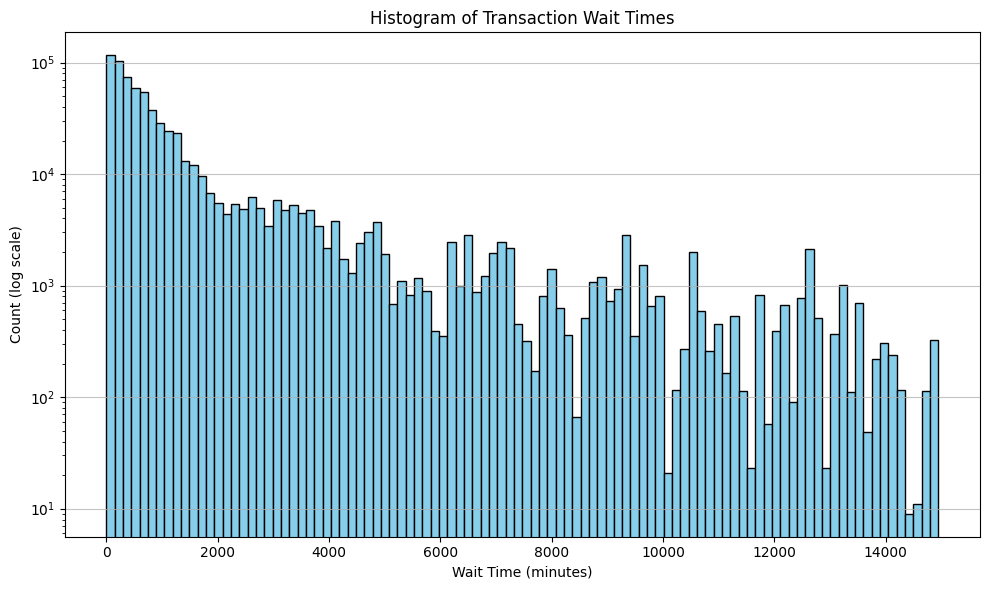

,mean,50%
RBF_flag,,
0,1443.901931,581.0
1,2288.757240,1005.5


In [11]:
#plot waittime histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['waittime'].dropna(), bins=100, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Transaction Wait Times')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

df.groupby('RBF_flag')['waittime'].describe()[['mean','50%']]


In [12]:
df.groupby('CPFP_flag')['waittime'].describe()[['mean','50%']]


,mean,50%
CPFP_flag,,
0,814.952220,435.0
1,2467.843469,1024.0


In [19]:
def estimate_first_stage_model(df):
    """
    Estimate a log-linear model for Equation 5: 
    log(Wq,t,i) = β₁ + β₂ log(ρ̂t+1) + β₃ log(Fᵗ(q)+1) + β₄ CPPit + β₅ RBFit + τq,t
    
    This is the first-stage estimation to de-bias the estimate for Phase 3.
    A log-linear model is used because wait times are strictly positive and skewed.
    """
    # Prepare data for regression
    model_data = df.dropna(subset=['waittime', 'rho_t', 'F_tq', 'CPFP_flag', 'RBF_flag']).copy()
    
    if len(model_data) == 0:
        print("✗ No valid data for regression after removing NaN values")
        return None, None
    
    # Transform regressors
    model_data['rho_t_log'] = np.log1p(model_data['rho_t'].clip(lower=0))
    model_data['F_tq_log']  = np.log1p(model_data['F_tq'].clip(lower=0))
    
    # Features (X)
    X = model_data[['rho_t_log', 'F_tq_log', 'CPFP_flag', 'RBF_flag']]
    
    # Target (y): Use the natural log of waittime. Use log1p to handle waittime=0.
    y = np.log1p(model_data['waittime'])
    
    # Fit linear regression on the log-transformed target
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions are on the log scale
    y_pred_log = model.predict(X)
    r2 = r2_score(y, y_pred_log)
    
    # Display results
    print("\n" + "="*60)
    print("PHASE 2: FIRST-STAGE ESTIMATION RESULTS (LOG-LINEAR MODEL)")
    print("="*60)
    print(f"Model: log(Wq,t,i + 1) = β₁ + β₂ log(ρ̂t+1) + β₃ log(Fᵗ(q)+1) + β₄ CPPit + β₅ RBFit + τq,t")
    print(f"\nSample size: {len(model_data):,} transactions")
    print(f"R² Score (on log-transformed waittime): {r2:.4f}")
    print(f"\nCoefficients (predicting log(waittime + 1)):")
    print(f"  β₁ (Intercept):         {model.intercept_:8.4f}")
    print(f"  β₂ (log(ρ̂t+1)):        {model.coef_[0]:8.4f}")
    print(f"  β₃ (log(Fᵗ(q)+1)):     {model.coef_[1]:8.4f}")
    print(f"  β₄ (CPFP):              {model.coef_[2]:8.4f}")
    print(f"  β₅ (RBF):               {model.coef_[3]:8.4f}")
    
    # Store predictions for Phase 3 on the original scale (minutes)
    # Use expm1 to reverse log1p.
    model_data['W_hat'] = np.expm1(y_pred_log)
    
    return model, model_data

estimate_first_stage_model(df)


PHASE 2: FIRST-STAGE ESTIMATION RESULTS (LOG-LINEAR MODEL)
Model: log(Wq,t,i + 1) = β₁ + β₂ log(ρ̂t+1) + β₃ log(Fᵗ(q)+1) + β₄ CPPit + β₅ RBFit + τq,t

Sample size: 696,424 transactions
R² Score (on log-transformed waittime): 0.2541

Coefficients (predicting log(waittime + 1)):
  β₁ (Intercept):          11.1143
  β₂ (log(ρ̂t+1)):         -0.5887
  β₃ (log(Fᵗ(q)+1)):       3.1948
  β₄ (CPFP):                1.4807
  β₅ (RBF):                 1.0156


(LinearRegression(),
                                               inputs_hash  \
 0       ddcfbe015c4c901784efc9ca31158ac31c66aa8beba0c1...   
 1       670fbe4984332d34dac0d7c371ac1a4774b038ce0a2d94...   
 2       0a55a0183fcabac48b53e2a5cc8104e825fc9c4c0e3c8c...   
 3       7743e04a2061d1d334f330eb5ff199345584d2b5f619d9...   
 4       b4ee52922bf8f46be13a4af52d1f0528fe2e38f01befcb...   
 ...                                                   ...   
 696419  15503da950118cb2bd8b3bacaab62c735bbd3dc5e4abc8...   
 696420  1b96047439dfd8e54ca4f082a2bcfff5fcc66b922da39b...   
 696421  55c5b767308b1394c6a969f27a63a24f8cc182c27e90c1...   
 696422  1e67e263b6d449282fdb32703c1f9575a807b710d6e8bb...   
 696423  d52049da7b0d96b29b85100c3145b0e7842da62d68db27...   
 
                                                     tx_id    found_at  \
 0       ddcfbe015c4c901784efc9ca31158ac31c66aa8beba0c1...  1750956422   
 1       67e0ff6cc21f816a8cba0bc24c8a4864f8263b9770b314...  1750956404   
 2       eb

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import Pipeline
from sklearn.linear_model  import LinearRegression

# Transform regressors to log(x+1)
df['rho_t_log'] = np.log1p(df['rho_t'].clip(lower=0))
df['F_tq_log']  = np.log1p(df['F_tq'].clip(lower=0))

num_cols  = ['rho_t_log', 'F_tq_log']
bin_cols  = ['CPFP_flag', 'RBF_flag']

pipe = Pipeline([
    ('scale', ColumnTransformer([
        ('num', StandardScaler(), num_cols)
    ], remainder='passthrough')),
    ('ols', LinearRegression())
])

X = df[num_cols + bin_cols]
y = np.log1p(df['waittime'])

pipe.fit(X, y)
print(dict(zip(['rho_t_log_z','F_tq_log_z','CPFP','RBF'],
               pipe.named_steps['ols'].coef_)))


{'rho_t_log_z': np.float64(-0.03152498080192075), 'F_tq_log_z': np.float64(0.5935216791327385), 'CPFP': np.float64(1.4806827342009086), 'RBF': np.float64(1.015581471368661)}


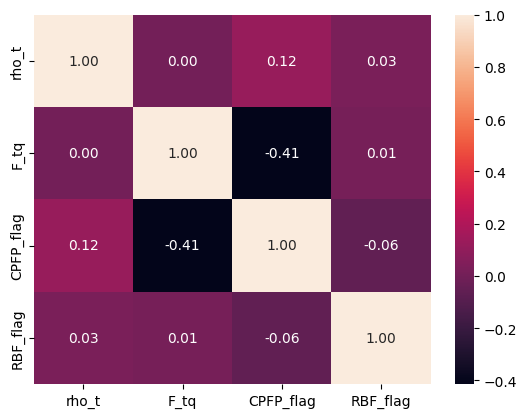

In [21]:
import seaborn as sns, matplotlib.pyplot as plt
corr = df[['rho_t', 'F_tq', 'CPFP_flag', 'RBF_flag']].corr()
sns.heatmap(corr, annot=True, fmt='.2f'); plt.show()


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Use log-transformed regressors
df['rho_t_log'] = np.log1p(df['rho_t'].clip(lower=0))
df['F_tq_log']  = np.log1p(df['F_tq'].clip(lower=0))
cols = ['rho_t_log', 'F_tq_log', 'CPFP_flag', 'RBF_flag']   # choose only numeric cols
Xnum = (df[cols]                    # 1. subset
        .astype(float)              # 2. force float64
        .dropna(how='any'))         # 3. remove rows with NaN/Inf

vifs = [variance_inflation_factor(Xnum.values, i) for i in range(Xnum.shape[1])]
print(dict(zip(cols, vifs)))


{'rho_t_log': np.float64(10.422389054493257), 'F_tq_log': np.float64(7.958274150341233), 'CPFP_flag': np.float64(1.9756670986720544), 'RBF_flag': np.float64(1.012633325796601)}


In [23]:
import statsmodels.formula.api as smf

# First-stage joint F-tests (Angrist-Pischke weak instrument check)
# Test whether selected coefficients are jointly zero using robust (HC3) covariance
# Use log-transformed regressors
df['rho_t_log'] = np.log1p(df['rho_t'].clip(lower=0))
df['F_tq_log']  = np.log1p(df['F_tq'].clip(lower=0))
f_df = df[['waittime', 'rho_t_log', 'F_tq_log', 'CPFP_flag', 'RBF_flag']].dropna()

mod_fs = smf.ols(
    'np.log1p(waittime) ~ rho_t_log + F_tq_log + CPFP_flag + RBF_flag',
    data=f_df
).fit(cov_type='HC3')

# Joint test of all predictors (excluding intercept)
ft_all = mod_fs.f_test('rho_t_log = 0, F_tq_log = 0, CPFP_flag = 0, RBF_flag = 0')
# First-stage "excluded instruments" set (example): congestion and tail distribution
ft_excl = mod_fs.f_test('rho_t_log = 0, F_tq_log = 0')

# Extract scalar F and p-values
f_all = float(np.asarray(ft_all.fvalue))
p_all = float(np.asarray(ft_all.pvalue))
f_excl = float(np.asarray(ft_excl.fvalue))
p_excl = float(np.asarray(ft_excl.pvalue))

print('First-stage joint F-tests (robust HC3):')
print(f'  All predictors jointly zero [log(ρ̂t+1), log(Fᵗ(q)+1), CPFP_flag, RBF_flag]: F = {f_all:.2f}, p = {p_all:.3g}')
print(f'  Excluded instruments only [log(ρ̂t+1), log(Fᵗ(q)+1)]: F = {f_excl:.2f}, p = {p_excl:.3g}')
print(f'  Weak instruments suspected (F < 10) on excluded set: {f_excl < 10}')


First-stage joint F-tests (robust HC3):
  All predictors jointly zero [log(ρ̂t+1), log(Fᵗ(q)+1), CPFP_flag, RBF_flag]: F = 63602.26, p = 0
  Excluded instruments only [log(ρ̂t+1), log(Fᵗ(q)+1)]: F = 68680.62, p = 0
  Weak instruments suspected (F < 10) on excluded set: False


Congestion (rho_t) variation across epochs
  epochs: 91 unique
  mean: 93,638.7, std: 4,349.1, CV: 0.0464
  min: 87,692.5, p25: 90,413.6, median: 93,038.0, p75: 95,711.2, max: 115,383.8
  IQR: 5,297.6, max/min: 1.3158
  log1p scale — mean: 11.4462, std: 0.0447, CV: 0.0039


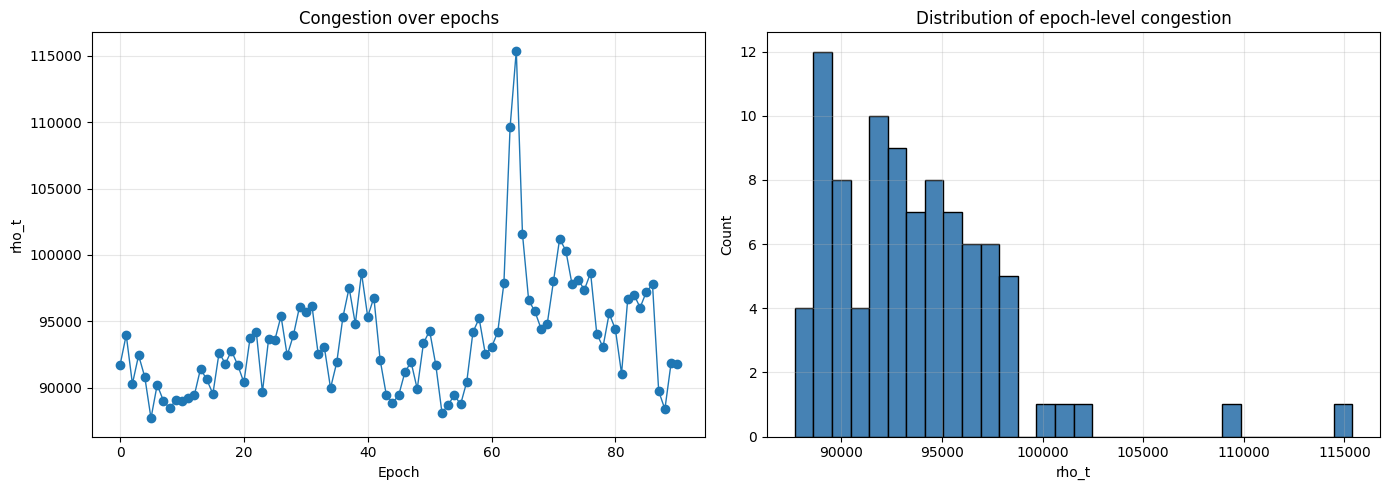

In [24]:
# Congestion variation analysis
# Quantify variation of epoch-level congestion (rho_t)

# Epoch-level series (rho_t is constant within epoch)
epoch_rho = (df[['epoch', 'rho_t']]
             .dropna()
             .drop_duplicates()
             .groupby('epoch')['rho_t']
             .mean()
             .sort_index())

rho_desc = epoch_rho.describe(percentiles=[.1,.25,.5,.75,.9])
rho_std = float(epoch_rho.std())
rho_mean = float(epoch_rho.mean())
cv = rho_std / rho_mean if rho_mean != 0 else np.nan
r_min, r_max = float(epoch_rho.min()), float(epoch_rho.max())
iqr = float(epoch_rho.quantile(.75) - epoch_rho.quantile(.25))
ratio = r_max / r_min if r_min > 0 else np.nan

# Log scale too
epoch_rho_log = np.log1p(epoch_rho.clip(lower=0))
rho_log_std = float(epoch_rho_log.std())
rho_log_mean = float(epoch_rho_log.mean())
cv_log = rho_log_std / rho_log_mean if rho_log_mean != 0 else np.nan

print("Congestion (rho_t) variation across epochs")
print(f"  epochs: {len(epoch_rho)} unique")
print(f"  mean: {rho_mean:,.1f}, std: {rho_std:,.1f}, CV: {cv:.4f}")
print(f"  min: {r_min:,.1f}, p25: {rho_desc['25%']:,.1f}, median: {rho_desc['50%']:,.1f}, p75: {rho_desc['75%']:,.1f}, max: {r_max:,.1f}")
print(f"  IQR: {iqr:,.1f}, max/min: {ratio:.4f}")
print(f"  log1p scale — mean: {rho_log_mean:.4f}, std: {rho_log_std:.4f}, CV: {cv_log:.4f}")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].plot(epoch_rho.index, epoch_rho.values, marker='o', lw=1)
axes[0].set_title('Congestion over epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('rho_t')
axes[0].grid(True, alpha=.3)

axes[1].hist(epoch_rho.values, bins=30, color='steelblue', edgecolor='black')
axes[1].set_title('Distribution of epoch-level congestion')
axes[1].set_xlabel('rho_t')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=.3)

plt.tight_layout()
plt.show()


Fee distribution by congestion decile (epoch-level):
              count         mean     50%           std    10%    25%     75%  \
rho_decile                                                                     
0           45791.0  1481.942958   564.0   7280.771773  240.0  338.0  1038.0   
1           57985.0  1174.979012   438.0   5640.864440  198.0  257.0   840.0   
2           57997.0  1355.766505   550.0   6084.117709  199.0  264.0  1120.0   
3           51936.0  1746.005738   678.0  18830.610824  220.0  354.0  1254.0   
4           73809.0  1066.079001   366.0   5523.837501  198.0  203.0   830.0   
5           58744.0  1358.664579   452.0   8779.005949  197.0  208.0   964.0   
6           92768.0   998.512828   304.0   4849.878331  197.0  197.0   717.0   
7           69493.0  1477.584275   508.0   7736.887937  199.0  282.0  1000.0   
8           98984.0  1268.481633   531.0  16953.551024  215.0  224.0  1030.0   
9           88917.0  2715.028015  1921.0   7803.711793  224.0  747.

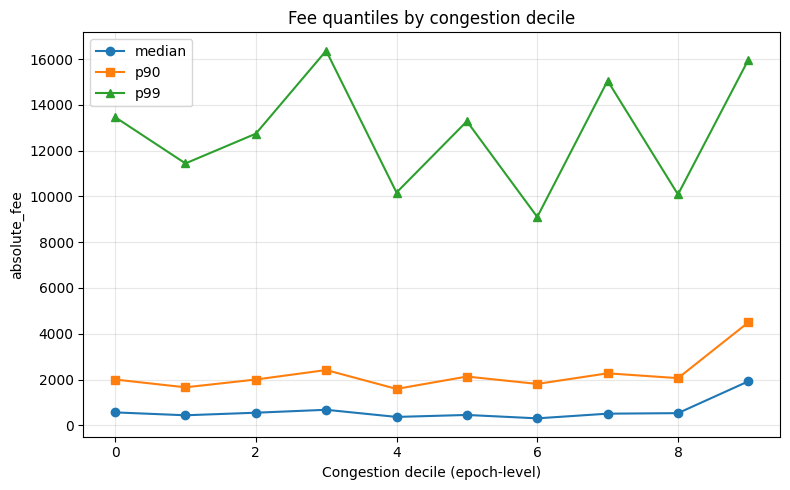

In [25]:
# Diagnose fee distribution conditional on congestion
# Compare fee distributions across congestion deciles to probe selection hypotheses

# Build deciles on epoch-level congestion and map back to transactions
epoch_rho = (df[['epoch','rho_t']]
             .dropna()
             .drop_duplicates()
             .groupby('epoch')['rho_t']
             .mean())

# Create deciles (10 buckets)
epoch_deciles = pd.qcut(epoch_rho, q=10, labels=False, duplicates='drop')

# Map decile to df
rho_dec_map = epoch_deciles.to_dict()
df['rho_decile'] = df['epoch'].map(rho_dec_map)

# Summary stats of fees by decile
fee_col = 'absolute_fee' if 'absolute_fee' in df.columns else 'fee_rate'
sumtab = (df[[fee_col, 'rho_decile']]
          .dropna()
          .groupby('rho_decile')[fee_col]
          .describe(percentiles=[.1,.25,.5,.75,.9]))
print('Fee distribution by congestion decile (epoch-level):')
print(sumtab[['count','mean','50%','std','10%','25%','75%','90%']])

# Plot fee median and upper tail vs decile
agg = (df[[fee_col, 'rho_decile']]
       .dropna()
       .groupby('rho_decile')[fee_col]
       .agg(median='median', p90=lambda x: np.percentile(x, 90), p99=lambda x: np.percentile(x, 99))
       .reset_index())

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(agg['rho_decile'], agg['median'], marker='o', label='median')
ax.plot(agg['rho_decile'], agg['p90'], marker='s', label='p90')
ax.plot(agg['rho_decile'], agg['p99'], marker='^', label='p99')
ax.set_title('Fee quantiles by congestion decile')
ax.set_xlabel('Congestion decile (epoch-level)')
ax.set_ylabel(fee_col)
ax.grid(True, alpha=.3)
ax.legend()
plt.tight_layout()
plt.show()


In [27]:
# Quick fixes for sign interpretation
# 1) Use impatience measure as lower-tail share: impatience = 1 - F_tq
# 2) Log-transform impatience and rho_t
# 3) Exclude CPFP/RBF from the regression to avoid reverse causality bias (optional toggle)

USE_EXCLUDE_BEHAVIORS = True  # set to False to include CPFP/RBF as controls

work = df.copy()

# Build impatience metric: higher => more impatient
work['impatience'] = 1.0 - work['F_tq']
# Guard against tiny negatives/NaN
work['impatience'] = work['impatience'].clip(lower=0).fillna(0)

# Log transforms for regressors
work['rho_t_log']       = np.log1p(work['rho_t'].clip(lower=0))
work['impatience_log']  = np.log1p(work['impatience'])

# Outcome transform
work['wait_log'] = np.log1p(work['waittime'])

# Choose X columns
base_X = ['rho_t_log', 'impatience_log']
if USE_EXCLUDE_BEHAVIORS:
    X_cols = base_X
else:
    X_cols = base_X + ['CPFP_flag', 'RBF_flag']

clean = work[['wait_log'] + X_cols].dropna()
X = clean[X_cols].astype(float)
y = clean['wait_log'].astype(float)

# Fit
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X, y)

# Report
print("Quick-fix first stage (log-log with impatience = 1 - F_tq)")
print(f"  n = {len(clean):,}")
print("  Coefficients:")
for name, coef in zip(X_cols, lin.coef_):
    print(f"    {name:15s}: {coef: .4f}")
print(f"  Intercept: {lin.intercept_: .4f}")
print(f"  R²: {lin.score(X, y):.4f}")

# If desired, robust OLS with joint F-test
import statsmodels.api as sm
import statsmodels.formula.api as smf

clean2 = work[['waittime','rho_t_log','impatience_log','CPFP_flag','RBF_flag']].dropna()
formula = 'np.log1p(waittime) ~ rho_t_log + impatience_log' + ('' if USE_EXCLUDE_BEHAVIORS else ' + CPFP_flag + RBF_flag')
ols = smf.ols(formula, data=clean2).fit(cov_type='HC3')
print("\nRobust OLS results (HC3):")
print(ols.summary().tables[1])

# Joint F-test on impatience and congestion only
ft = ols.f_test('rho_t_log = 0, impatience_log = 0')
print(f"Joint F-test [rho_t_log, impatience_log]: F={float(np.asarray(ft.fvalue)):.2f}, p={float(np.asarray(ft.pvalue)):.3g}")

# Sanity: signs should be β_rho_t_log >? and β_impatience_log < 0 per theory
beta = dict(zip(X_cols, lin.coef_))
print("\nSign check:")
print(f"  impatience_log coefficient negative? {beta.get('impatience_log', np.nan) < 0}")
if 'rho_t_log' in beta:
    print(f"  rho_t_log sign: {np.sign(beta['rho_t_log']):+.0f} (interpretation depends on congestion effect)")


Quick-fix first stage (log-log with impatience = 1 - F_tq)
  n = 696,424
  Coefficients:
    rho_t_log      :  1.1378
    impatience_log : -1.2765
  Intercept: -6.2626
  R²: 0.0343

Robust OLS results (HC3):
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.2626      0.353    -17.757      0.000      -6.954      -5.571
rho_t_log          1.1378      0.031     36.981      0.000       1.078       1.198
impatience_log    -1.2765      0.008   -155.959      0.000      -1.293      -1.260
Joint F-test [rho_t_log, impatience_log]: F=12916.47, p=0

Sign check:
  impatience_log coefficient negative? True
  rho_t_log sign: +1 (interpretation depends on congestion effect)
